# ECE 396 - HHL Algorithm
## Preparing the 3x3 invertible, non-hermitian A for HHL. 

First, import the necessary packages.

In [497]:
import numpy as np
from numpy import pi
import scipy
from qiskit.extensions import UnitaryGate
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister, execute
from qiskit.visualization import plot_histogram


We need to define a 3 x 3 invertible but non-hermitian A in Qiskit. That is, the following two qualities must hold:
$$AA^{-1} = A^{-1}A = I_n$$
$$A \neq A^{\dag}$$
If we restric ourselves to only real values, the matrix we can choose must then follow the two qualities: invertible and $A\neq A^T$.

One such matrix is the following:

$$A = \Bigg(\begin{matrix}
    1 & 0 & 0 \\
    0 & 1 & 0 \\
    0 & 1 & 1 
\end{matrix}\Bigg)$$


In [498]:
A = np.matrix([[1, 0.12, 0], [0.5, 0, 0.88], [0, 1, 1]])
print(A)

[[1.   0.12 0.  ]
 [0.5  0.   0.88]
 [0.   1.   1.  ]]


Before I can use the HHL algorithm, we need to convert the non-hermitian matrix into a hermitian matrix form. We can complete this by performing the operation defined in the article. That is, define:
$$A' = \Bigg(\begin{matrix}
    0 & A \\
    A^{\dag} & 0 \end{matrix}\Bigg)$$
A' is now hermitian and can be used to solve  $A'\cdot y = \Bigg[\begin{matrix} b  \\ 0 \end{matrix}\Bigg]$; where $y = \Bigg[\begin{matrix} 0  \\ x \end{matrix}\Bigg]$

In [499]:
# define a 3x3 zero matrix for aid in construction
zero = np.matrix([[0, 0, 0], [0, 0, 0], [0, 0, 0]])

# construct A' to be a hermitian matrix
Ap = np.vstack((np.hstack((zero, A)), np.hstack((A.getH(), zero))))
print(Ap)

[[0.   0.   0.   1.   0.12 0.  ]
 [0.   0.   0.   0.5  0.   0.88]
 [0.   0.   0.   0.   1.   1.  ]
 [1.   0.5  0.   0.   0.   0.  ]
 [0.12 0.   1.   0.   0.   0.  ]
 [0.   0.88 1.   0.   0.   0.  ]]


HHL requires that the matrix $A$ is a $2^n x 2^n$ matrix. Our $A'$ is currently $6x6$, so we need to pad it to extend it to $8x8$. Our padding constraints need to maintain invertibility and hermitian-ness. To accomplish this, we pad the matrix to have 1's along the diagonal of the 2 added dimensions. For consistency, let's continue to call this matrix $A'$.

In [500]:
A_p = np.pad(Ap, ((0, 2), (0, 2)))

# pad 
A_p[-1][-1], A_p[-2][-2] = 1, 1
print(A_p)


[[0.   0.   0.   1.   0.12 0.   0.   0.  ]
 [0.   0.   0.   0.5  0.   0.88 0.   0.  ]
 [0.   0.   0.   0.   1.   1.   0.   0.  ]
 [1.   0.5  0.   0.   0.   0.   0.   0.  ]
 [0.12 0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.88 1.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.  ]]


Let's inspect the eigenvalues of this matrix. HHL requires positive eigenvalues and also it is necessary for conditional rotation.

In [501]:
eig_val, eig_vec = scipy.linalg.eig(A_p)

print("-"*30)
print(f"Eigen Values:")
for e_val in eig_val:
    print(e_val)
print("-"*30)
print(f"Eigen Vectors:")
print(eig_vec)


------------------------------
Eigen Values:
(1.6131163758439162+0j)
(1.0669404670300013+0j)
(0.546162611131514+0j)
(-1.6131163758439153+0j)
(-1.0669404670300018+0j)
(-0.5461626111315144+0j)
(1+0j)
(1+0j)
------------------------------
Eigen Vectors:
[[ 0.16136857  0.59565599 -0.34518708  0.16136857 -0.59565599  0.34518708
   0.          0.        ]
 [ 0.37364971  0.22200321  0.55776381  0.37364971 -0.22200321 -0.55776381
   0.          0.        ]
 [ 0.57822667 -0.309691   -0.26409356  0.57822667  0.309691    0.26409356
   0.          0.        ]
 [ 0.2158514   0.66232149 -0.12140189 -0.2158514   0.66232149 -0.12140189
   0.          0.        ]
 [ 0.3704574  -0.2232667  -0.55938654 -0.3704574  -0.2232667  -0.55938654
   0.          0.        ]
 [ 0.56228951 -0.10715516  0.41514851 -0.56228951 -0.10715516  0.41514851
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   1.          0.        ]
 [ 0.          0.          0.          0.         

Similarly, we initialize and pad the $b$ solution vector. 

In [502]:
# initialize the b solution vector
b = np.array([1, 3, 2])

# pad the b array with 0's to be 8 by 1
b_p = np.append(b, [0, 0, 0, 0, 0])


In [503]:
print(A_p.shape)
print(b_p.shape)

(8, 8)
(8,)


Before implementing HHL ourselves, let's test it using Qiskit's pre-made model of HHL to be sure that our inputs work and to save to compare to in later testing stages.

In [504]:
# from qiskit import Aer
# from qiskit.algorithms.linear_solvers.hhl import HHL

# backend = Aer.get_backend('aer_simulator')
# hhl = HHL(quantum_instance=backend)

# accurate_solution = hhl.solve(A_p, b_p)


## Implementing the HHL algorithm

### Defining parameters

Some parameters should be chosen based on the conditional number of the matrix A. That is, C, used in conditional rotation should be on the order of $1/\kappa$ where $\kappa$ is the conditional number of the matrix A. If $\kappa$ is too large, some of the rows of A will be very linearly dependent and thus the inverse of A is very unstable.

In [505]:
kappa = np.linalg.cond(A_p)
print(f"Kappa = {kappa}")

Kappa = 2.9535459640892223


We have 3 parameters for HHL. 
- $T$ is used during the exponentiation of the matrix $A'$ ($e^{i\cdot A'\cdot T}$). $T$ needs to be relatively large so that the Fourier transofrm of the conditional Hamiltonian evolution of $A'$ (Eq 3 in the reference paper) has an $\alpha$ that acts as a sync function. 
- $C$ is used during conditional rotation. $C$ needs to be on the order of $1/\kappa$ where $\kappa$ is the conditional number of $A'$ as described previously.
- $n_{eig}$ is used during QPE and defines the number of qubits used to estimate the eigenvalues of $A'$ up to $n_{eig}$ bits of precision.

In [506]:
T = 100 # Used in hamiltonian evolution. Needs to be relatively large so that alpha in Eq (3) approximates as sync functions
C = 1/2 # Used in conditional rotation. Needs to be on the order of 1/kappa where kappa is the conditional number of A
n_eig = 6 # Used in QPE, number of qubits to estimate the eigenvalues of A, defines the precision of the eigenvalues up to n_eig bits

n = 3 # 2**n x 2**n A. This defines the number of qubits needed for the dimensions of this problem. Specifically 8 dimensions can be encoded with 3 qubits. 


### Loading The Data

In [507]:
aux = QuantumRegister(1, 'aux') # for conditional eigenvalue inversion

n_l = QuantumRegister(n_eig, 'nl') # stores binary representation of the eigenvalues 
n_a = QuantumRegister(n,'na') # auxillary qubits (can be ignored...?)
n_b = QuantumRegister(n, 'nb') # contains the vector solution

c = ClassicalRegister(n_eig, 'c')

init_circ = QuantumCircuit(aux, n_l, n_a, n_b, c)

# state preparation of b: |0> -> |b>
b_p = b_p/scipy.linalg.norm(b_p) # normalize b, so it is ready for loading.
init_circ.initialize(b_p, n_b)


### Quantum Phase Estimation

We'll start by converting $A'$ to be a unitary operator by exponentiating it $e^{i\cdot A'\cdot T}$ and using Qiskit to convert to a unitary operator.

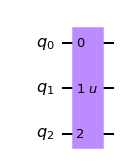

In [508]:
# convert to unitary matrix through exponentiation
U_mat = scipy.linalg.expm(1j*A_p*T)

# convert to a unitary operator with Qiskit
U = UnitaryGate(U_mat)
U.name = "$U$"
# define the control gate used in QPE
U_ctrl = U.control()
U_ctrl.label = "C-U"

# print out the how the circuit will look
example_circ = QuantumCircuit(3)
example_circ.append(U, range(3))
example_circ.draw('mpl')
# then calculate eigenvalues to see if they are nice...?

The following is the circuit implementation for QPE.

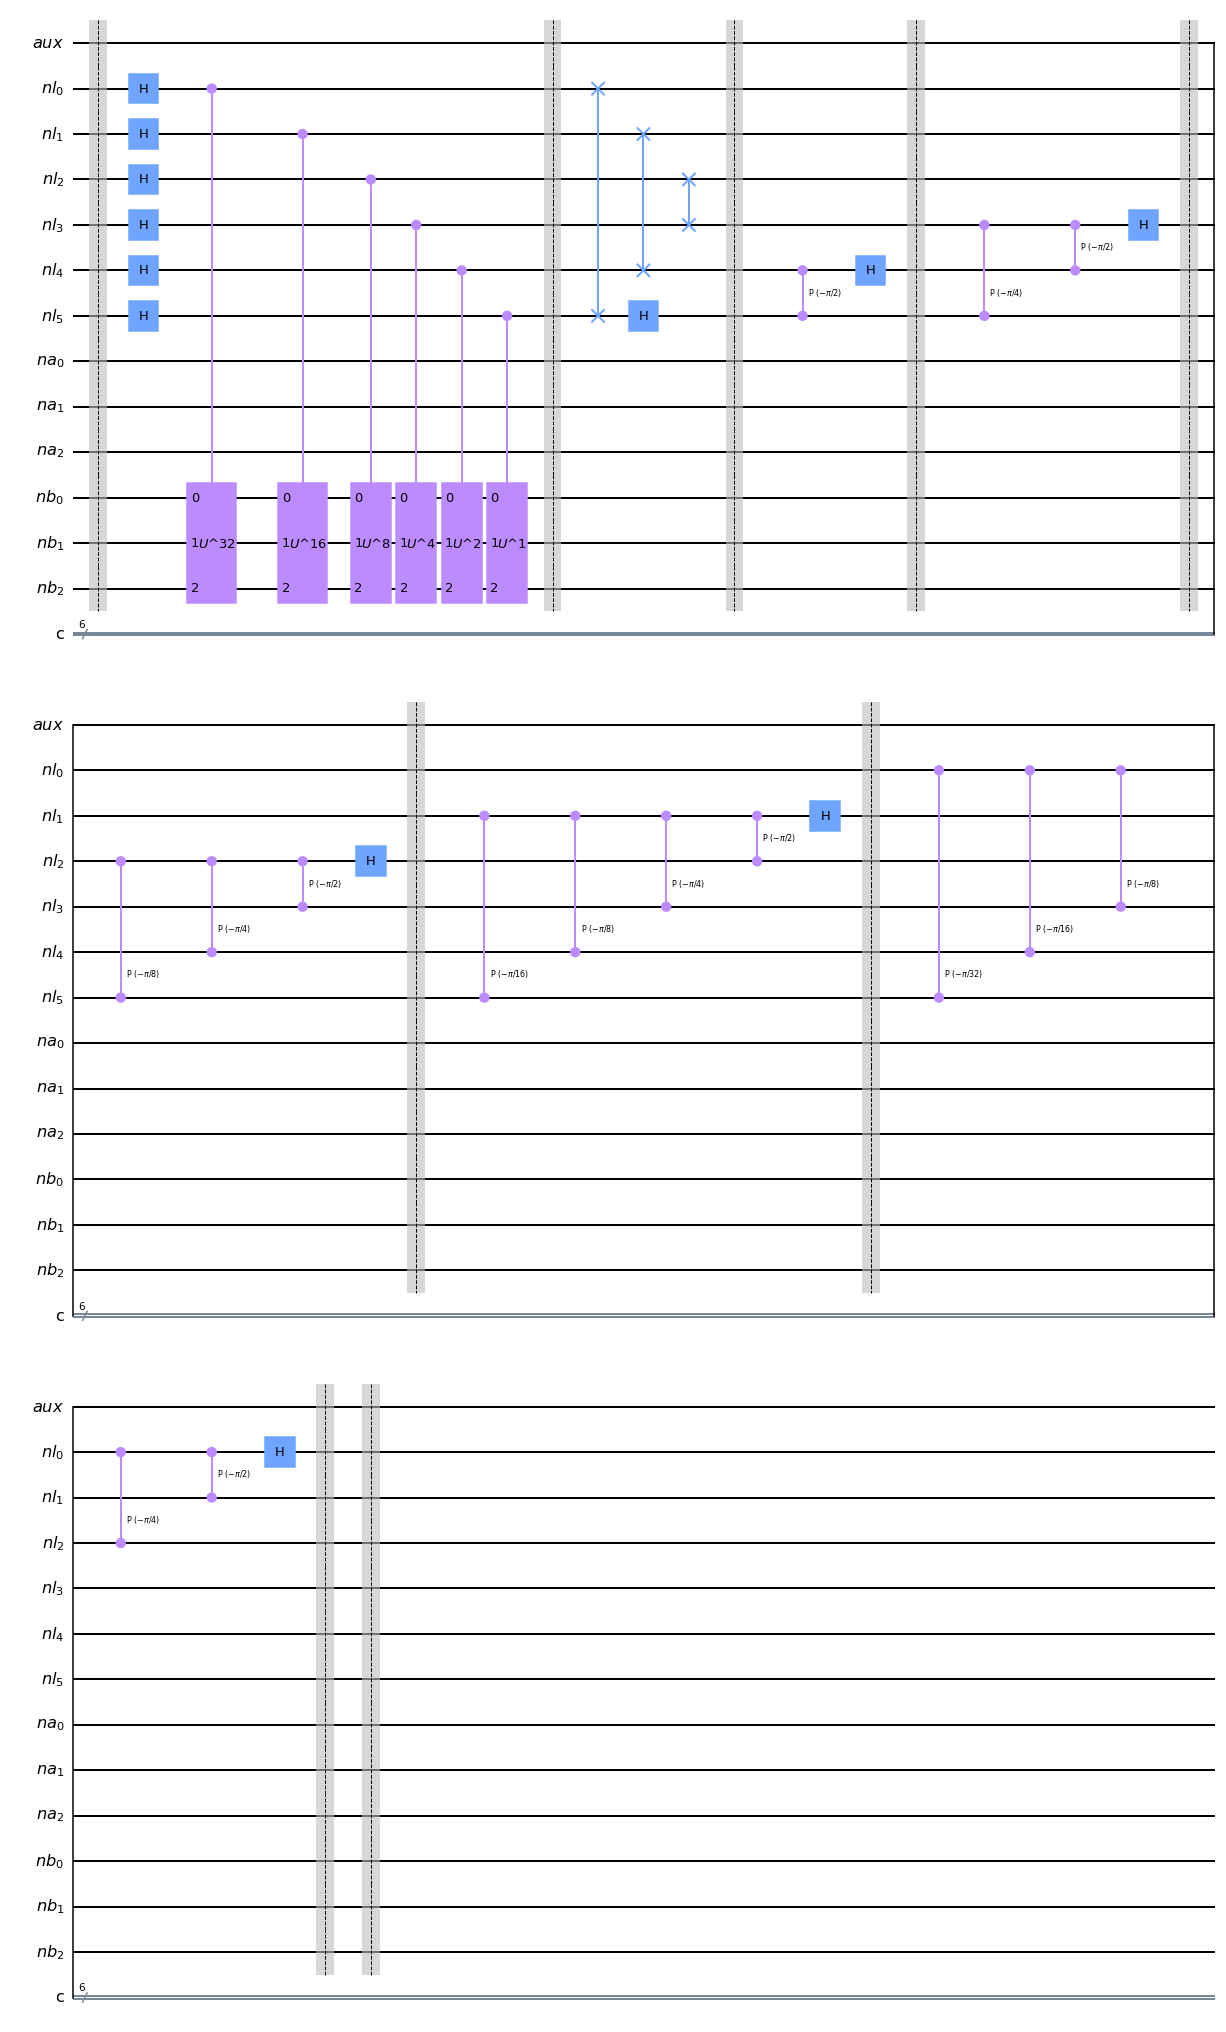

In [509]:
qpe_circ = QuantumCircuit(aux, n_l, n_a, n_b, c)
qpe_circ.barrier()

# First, perform a hadamard on all the memory qubits.
qpe_circ.h(n_l)

# Apply powers of controlled U on the target qubits 
for i in range(n_eig): 
    Upow = U.power(2**(n_eig-1-i)) 
    ctrl_Upow = Upow.control() 
    qpe_circ.append(ctrl_Upow, [n_l[i], n_b[0], n_b[1], n_b[2]]) 
qpe_circ.barrier() 

# Compute the inverse quantum fourier transform 
for qubit in range(n_eig//2): 
    qpe_circ.swap(n_l[qubit], n_l[n_eig-qubit-1]) 
for i in range(n_eig): 
    for m in range(i): 
        qpe_circ.cp(-pi/(2**(i-m)), n_l[n_eig-1-m], n_l[n_eig-1-i])
    qpe_circ.h(n_l[n_eig-1-i])
    qpe_circ.barrier()
qpe_circ.barrier()

qpe_circ.draw('mpl')

#### Testing our QPE through repeated measurement.

To test our QPE implementation and inspect the estimated phase of the exponentiated matrix, we repeatedly measure the encoded qubits $n_l$.

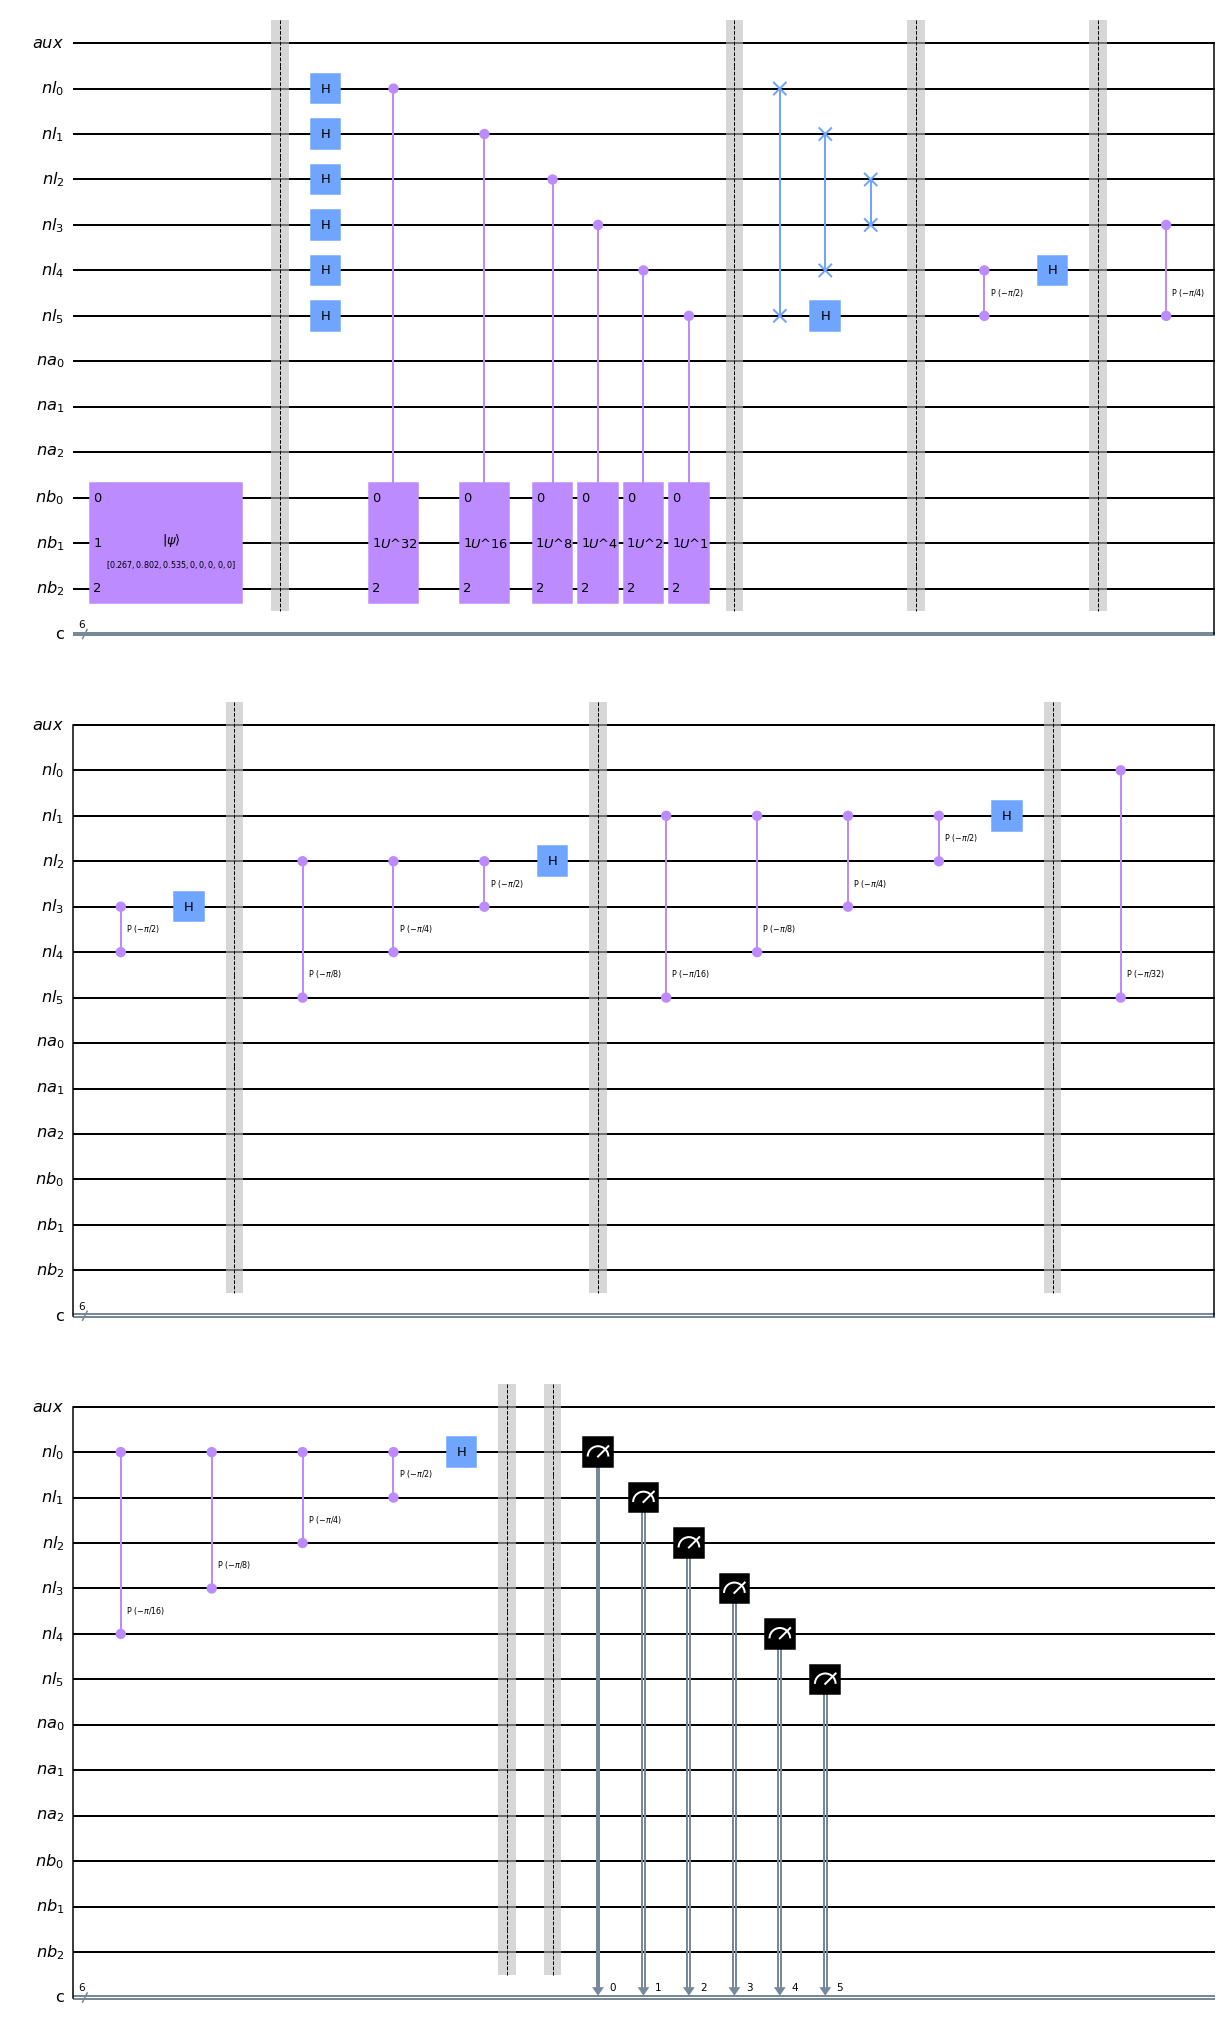

In [510]:
measure_circ = init_circ.compose(qpe_circ)
measure_circ.measure(n_l, c)

measure_circ.draw('mpl')

To test working condition, let's measure the $n_l$ qubits to see if the eigenvalues of A are being sufficiently encoded.

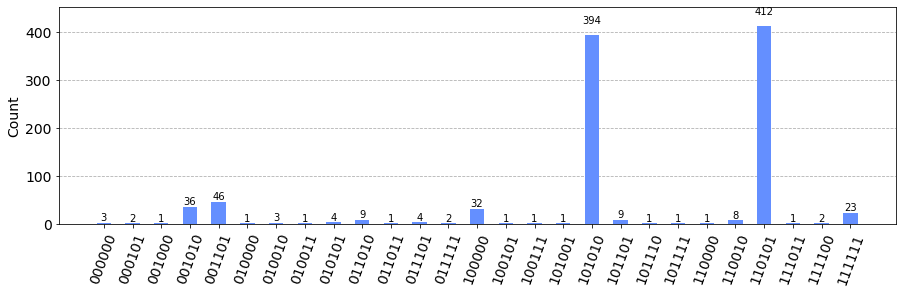

In [511]:
nShots = 1000

backend_qasm = Aer.get_backend('qasm_simulator')
# perform constant_full_circuit just 1 time and plot the histogram of states! 
res = execute(measure_circ, backend_qasm,shots=nShots).result() 
counts = res.get_counts(); 
plot_histogram(counts, figsize=(15,4))

Evaluating the outputs of QPE to match the expected eigenvalues of the matrix.

In [512]:
def calculate_lmd_dec(bit_str):
    lmd = 0
    for ind, i in enumerate(bit_str[::-1]):
        lmd += int(i)/2**(ind+1)

    return lmd

def binaryToDec(n):
    return int(n, 2)


top_six_phase = [i[0] for i in sorted(counts.items(), key=lambda i: i[1], reverse=True)[:6]]
print(top_six_phase)

top_six_dec = [binaryToDec(i[::-1]) for i in top_six_phase]
top_six_dec


['110101', '101010', '001101', '001010', '100000', '111111']


[43, 21, 44, 20, 1, 63]

In [513]:
eigenvals = np.real(eig_val)
dec_reps = [int(2**n_eig * T * val / (2*pi) % (2**n_eig)) for val in eigenvals] # should see the binary rep of 58 in the histogram. 
dec_reps
# how we find the lambda. 


[43, 62, 44, 20, 1, 19, 58, 58]

We can see in this comparison between the real eigenvalues and those that QPE output. Comparing the two arrays: $43=43$, $21=20 \text{ or } 19$, $44=44$, $20=20 \text{ or } 19$, $1=1$, $63=62$ with some slight approximation errors. In this way, we have verified that the QPE algorithm is successful.

### Eigenvalue inversion.



Using the eigenvalues output from QPE, we can construct a circuit that rotates conditionally based on these eigenvalues.

In [514]:
eigenvalues = top_six_phase

Because of arcsin in rotation the parameter $C$ must be smaller than the smallest eigenvalue. As stated before, $C$ should be on the order of $1/\kappa$ where $\kappa$ is the conditional number of the matrix. Our conditional number was calculated to be $\kappa\approx 2.53$.


In [523]:
C = min([calculate_lmd_dec(i) for i in eigenvalues]) - 0.01
C

0.005625

The following is the circuit construction.

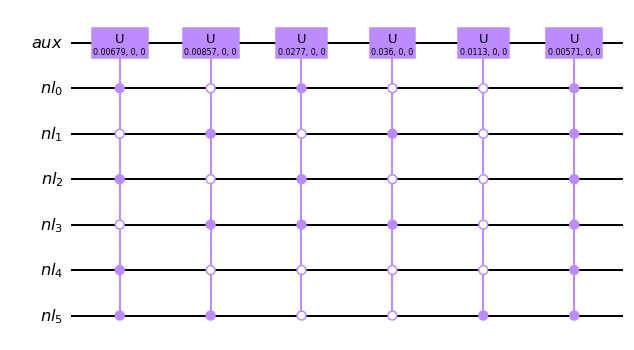

In [524]:
# circuit construction
from qiskit.circuit.library.standard_gates import UGate
import math

def theta_angle(C, eigenvalue_bin):
    eigenvalue = int(eigenvalue_bin, 2)/(2**n_eig)
    ratio = C/eigenvalue
    return math.asin(ratio)

eig_invert_circ = QuantumCircuit(aux, n_l)

for ev in eigenvalues:
    rot_angle = theta_angle(C, ev)
    cu_gate = UGate(rot_angle, 0, 0).control(n_eig, ctrl_state = ev)
    wiring = [i for i in range(1, n_eig+1)]+[0]
    eig_invert_circ.append(cu_gate, wiring)
eig_invert_circ.draw('mpl')

### Reverse QPE.

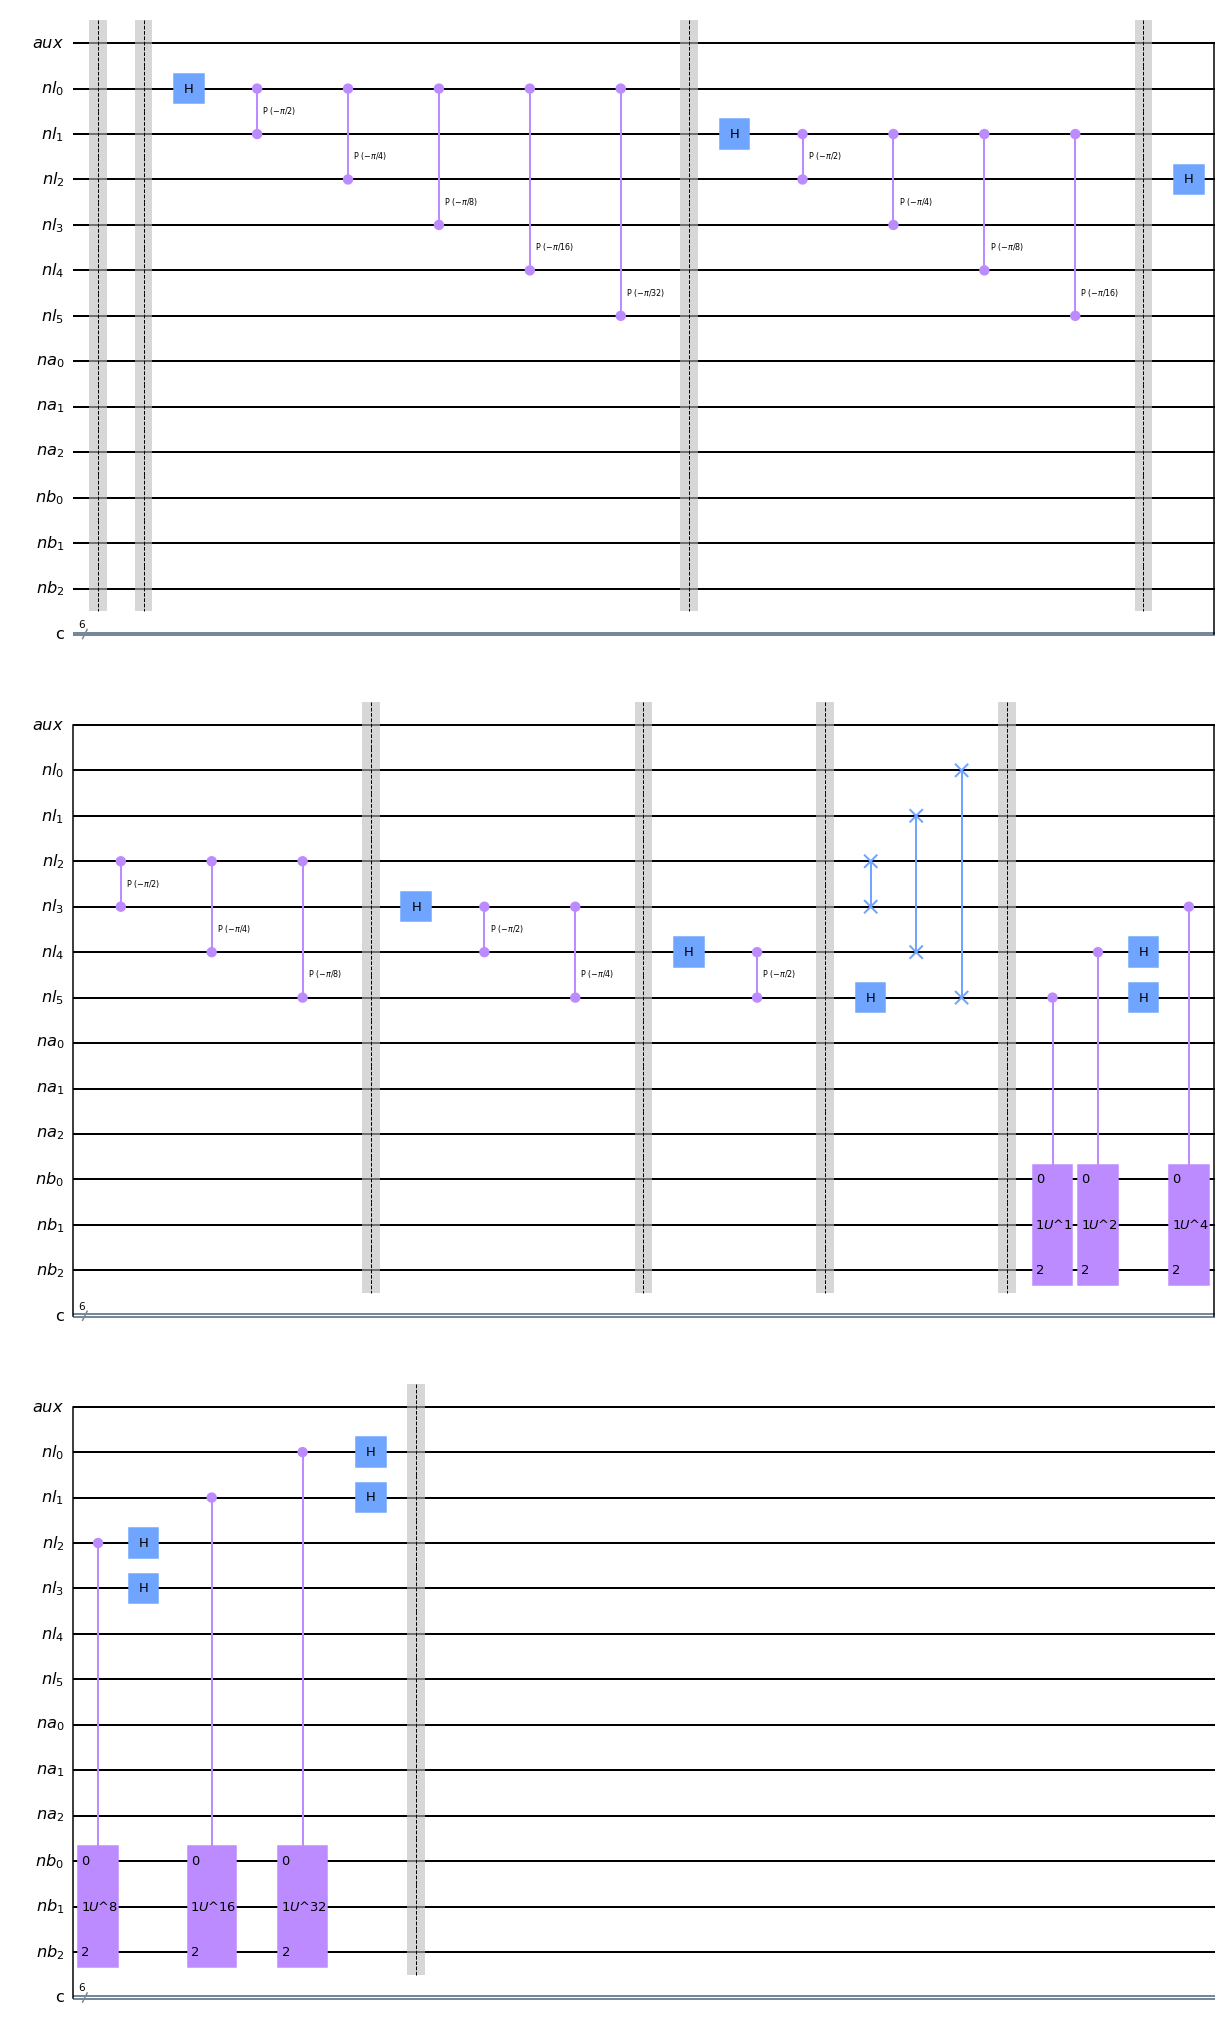

In [516]:
reverse_qpe_circ = qpe_circ.reverse_ops()
reverse_qpe_circ.draw('mpl')

### Putting it all together

We can summarize each of the circuit parts as the following.
- `init_circ` defines the loading of data $|b\rangle$ into the $n_b$ qubits.
- `qpe_circ` defines the circuit for quantum phase estimation, encoding the eigenvalues of $A'$ into the $n_l$ qubits. 
- `eig_invert_circ` defines the eigenvalue inversion circuit.
- `reverse_qpe_circ` defines the reverse qpe circuit.


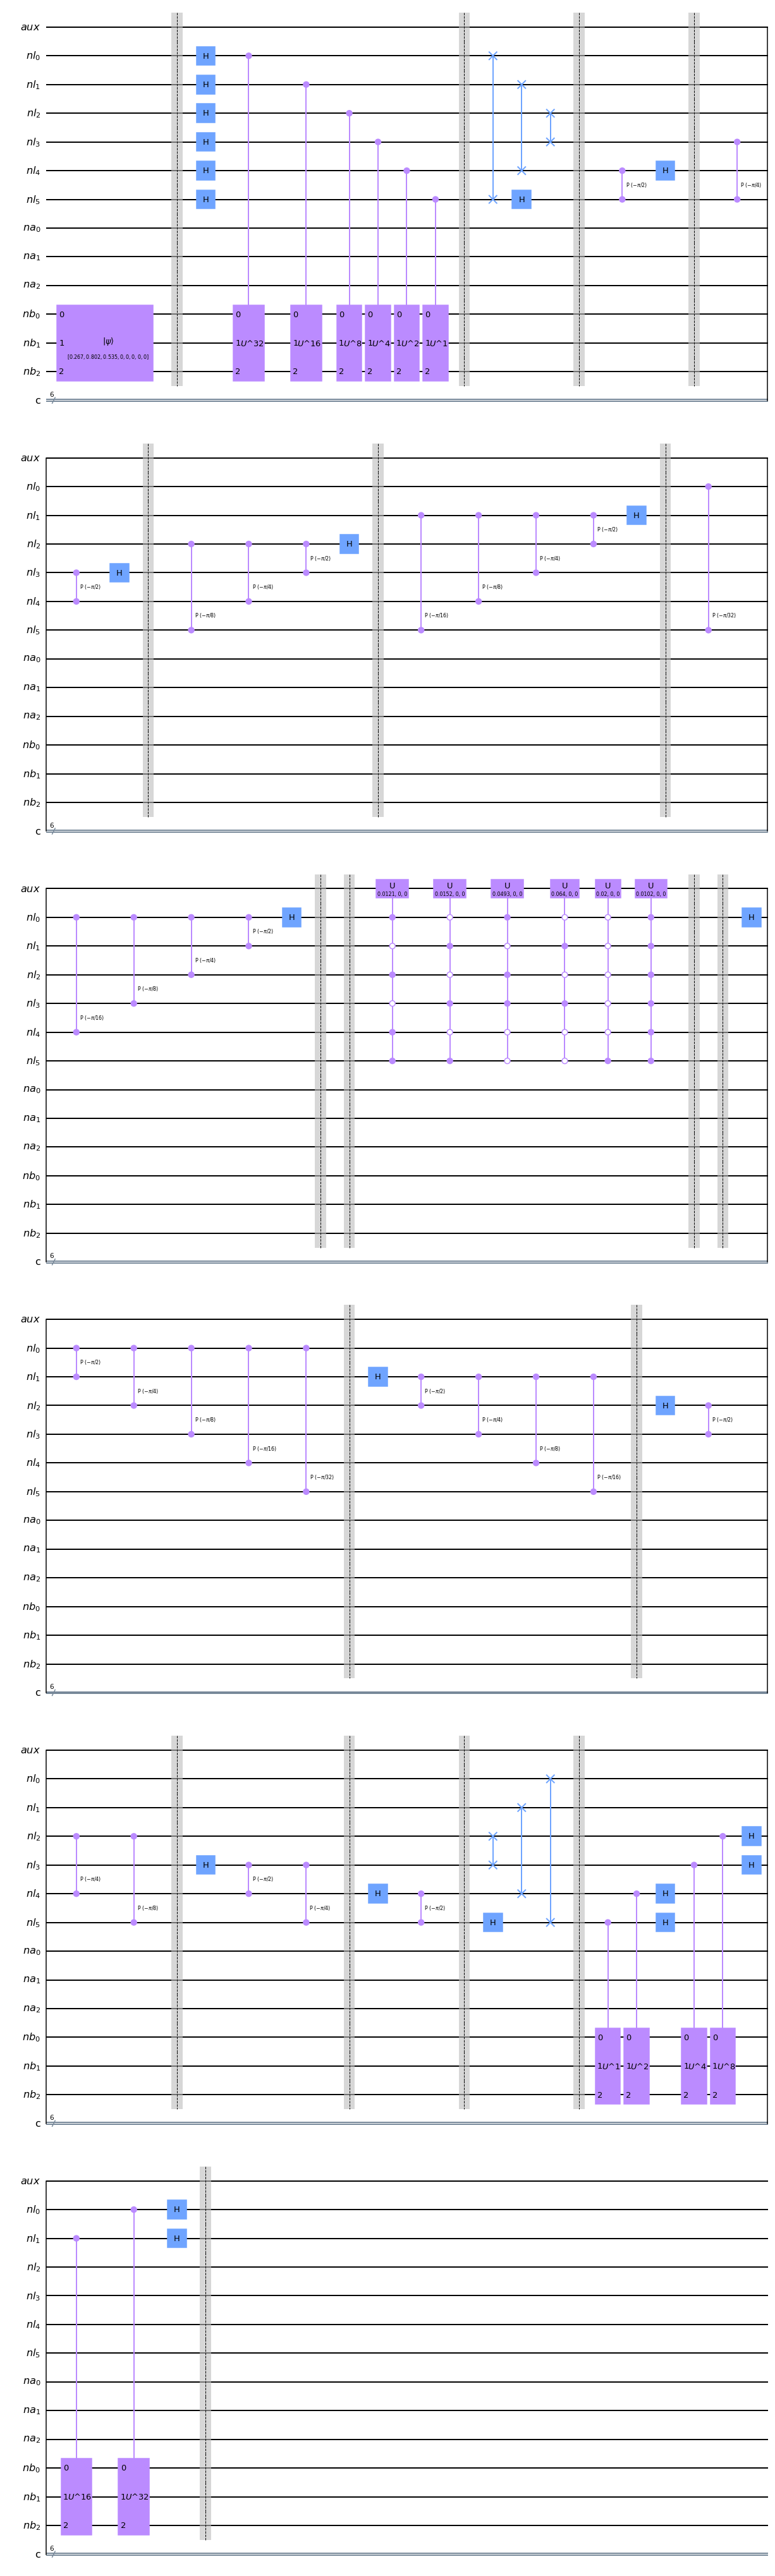

In [517]:
circ_up_to = init_circ.compose(qpe_circ).compose(eig_invert_circ).compose(reverse_qpe_circ)

circ_up_to.draw('mpl')

We need to measure the auxilliary qubit to verify that the output is 1 before proceedig. If it isn't, rerun the circuit. 

In [518]:
circ_up_to.measure(aux, c[0])

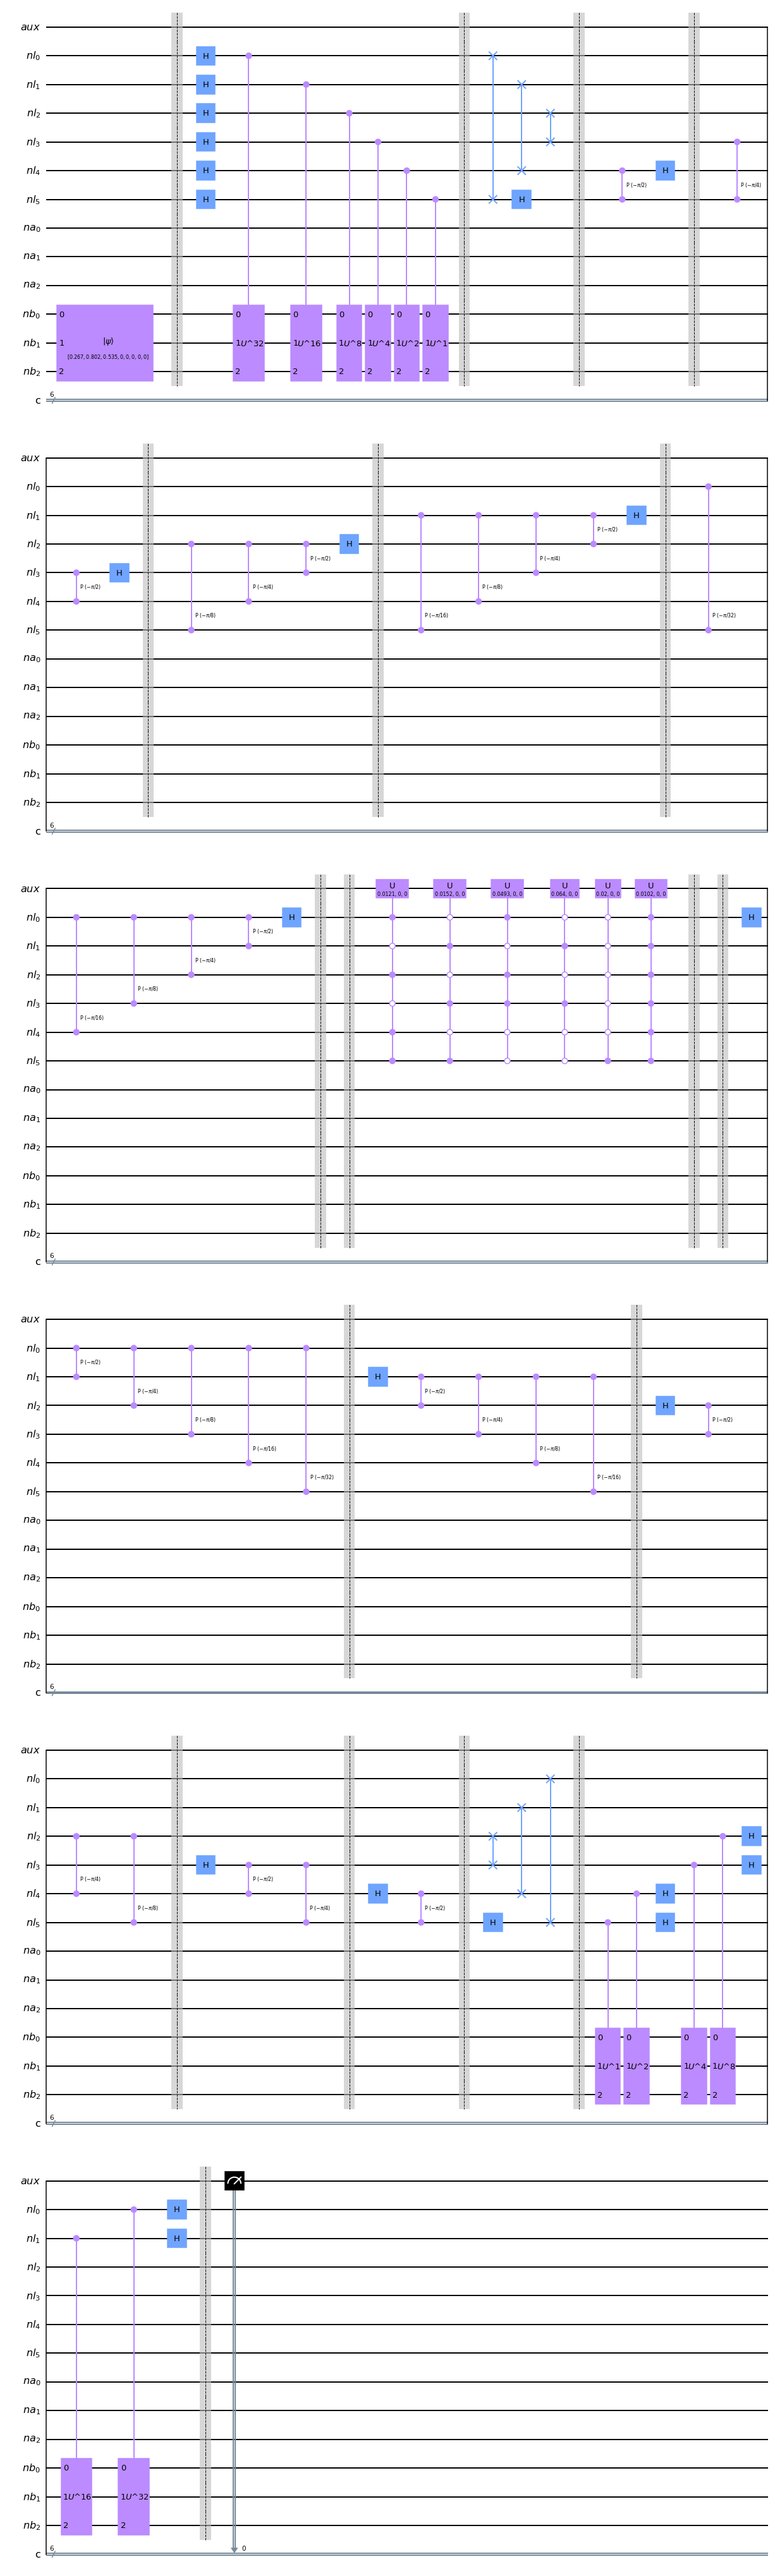

In [526]:
circ_up_to.draw('mpl')

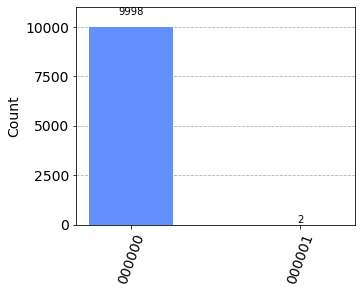

In [531]:
#
backend_qasm = Aer.get_backend('qasm_simulator')
# perform constant_full_circuit just 1 time and plot the histogram of states! 
res = execute(circ_up_to, backend_qasm,shots=10000).result() 
counts = res.get_counts(); 
plot_histogram(counts, figsize=(5,4))